#### 通过RNN使用imdb数据集完成情感分类任务

In [1]:
from __future__ import absolute_import,print_function,division,unicode_literals
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import os

tf.__version__

D:\Anaconda3.5.20\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3.5.20\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3.5.20\envs\tensorflow2.0\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3.5.20\envs\tensorflow2.0\lib\site-packages\tensorflow\pyth

'2.0.0-beta0'

In [2]:
tf.random.set_seed(22)
np.random.seed(22)
os.environ['TF_CPP_LOG_LEVEL'] = '2'

In [3]:
# 超参数
vocab_size = 10000
max_review_length = 80
embedding_dim = 100
units = 64
num_classes = 2
batch_size = 32
epochs = 10

In [4]:
# 加载数据集
imdb = keras.datasets.imdb
(train_data,train_labels),(test_data,test_labels) = imdb.load_data(num_words = vocab_size)
train_data[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [5]:
len(train_data)

25000

In [6]:
# 建立词典
word_index = imdb.get_word_index()

word_index = {k:(v + 3) for k ,v in word_index.items()}

word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
word_index["<UNSED>"] = 3

reversed_word_index = dict([(value,key) for (key,value)  in word_index.items()])

In [7]:
def decode_review(text):
    return ' '.join([reversed_word_index.get(i,'?') for i in text])
                     
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
train_data = train_data[:20000]
val_data = train_data[20000:25000]

train_labels = train_labels[:20000]
val_labels = train_labels[20000:25000]

In [9]:
# 补齐数据
train_data = keras.preprocessing.sequence.pad_sequences(train_data,value = word_index["<PAD>"],padding = 'post',maxlen = max_review_length )
test_data = keras.preprocessing.sequence.pad_sequences(test_data,value = word_index["<PAD>"],padding = 'post',maxlen = max_review_length )

train_data[0]

array([  15,  256,    4,    2,    7, 3766,    5,  723,   36,   71,   43,
        530,  476,   26,  400,  317,   46,    7,    4,    2, 1029,   13,
        104,   88,    4,  381,   15,  297,   98,   32, 2071,   56,   26,
        141,    6,  194, 7486,   18,    4,  226,   22,   21,  134,  476,
         26,  480,    5,  144,   30, 5535,   18,   51,   36,   28,  224,
         92,   25,  104,    4,  226,   65,   16,   38, 1334,   88,   12,
         16,  283,    5,   16, 4472,  113,  103,   32,   15,   16, 5345,
         19,  178,   32])

In [25]:
# 构建模型
class RNNModel(keras.Model):
    
    def __init__(self,units,num_classes,num_layers):
        super(RNNModel,self).__init__()
        
        self.units = units
        
        self.embedding = keras.layers.Embedding(vocab_size,embedding_dim,input_length = max_review_length)
        """
        self.lstm = keras.layers.LSTM(units,return_sequences = True)
        self.lstm_2 = keras.layers.LSTM(units)
        """
        
        self.lstm = keras.layers.Bidirectional(keras.layers.LSTM(self.units))
        
        self.dense = keras.layers.Dense(1)
        
    def call(self,x,training = None,mask = None):
        x = self.embedding(x)
        x = self.lstm(x)
        x = self.dense(x)
        
        return x

In [26]:
model.summary()

Model: "rnn_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      multiple                  1000000   
_________________________________________________________________
bidirectional_2 (Bidirection multiple                  84480     
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 1,084,545
Trainable params: 1,084,545
Non-trainable params: 0
_________________________________________________________________


In [27]:
model = RNNModel(units,num_classes,num_layers=2)

model.compile(optimizer = keras.optimizers.Adam(0.001),
              loss = keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'])

model.fit(train_data,train_labels,
          epochs = epochs,batch_size = batch_size,
          validation_data = (test_data,test_labels))


Train on 20000 samples, validate on 25000 samples
Epoch 1/10
20000/20000 [==============================] - 119s 6ms/sample - loss: 0.4345 - accuracy: 0.7793 - val_loss: 0.3622 - val_accuracy: 0.8403
Epoch 2/10
20000/20000 [==============================] - 94s 5ms/sample - loss: 0.2686 - accuracy: 0.8849 - val_loss: 0.3942 - val_accuracy: 0.8364
Epoch 3/10
20000/20000 [==============================] - 113s 6ms/sample - loss: 0.1766 - accuracy: 0.9287 - val_loss: 0.4598 - val_accuracy: 0.8191
Epoch 4/10
20000/20000 [==============================] - 98s 5ms/sample - loss: 0.1019 - accuracy: 0.9613 - val_loss: 0.5437 - val_accuracy: 0.8107
Epoch 5/10
20000/20000 [==============================] - 113s 6ms/sample - loss: 0.0512 - accuracy: 0.9819 - val_loss: 0.6878 - val_accuracy: 0.8104
Epoch 6/10
20000/20000 [==============================] - 94s 5ms/sample - loss: 0.0294 - accuracy: 0.9902 - val_loss: 0.9285 - val_accuracy: 0.8113
Epoch 7/10
20000/20000 [=============================

In [28]:
model.summary()

Model: "rnn_model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      multiple                  1000000   
_________________________________________________________________
bidirectional_3 (Bidirection multiple                  84480     
_________________________________________________________________
dense_3 (Dense)              multiple                  129       
Total params: 1,084,609
Trainable params: 1,084,609
Non-trainable params: 0
_________________________________________________________________


In [29]:
result = model.evaluate(test_data,test_labels)
# output:loss: 0.6751 - accuracy: 0.8002

25000/25000 [==============================] - 22s 899us/sample - loss: 0.9899 - accuracy: 0.7985


In [30]:
def GRU_Model():
    model = keras.Sequential([
        keras.layers.Embedding(input_dim = vocab_size,output_dim = 32,input_length = max_review_length),
        keras.layers.GRU(32,return_sequences = True),
        keras.layers.GRU(1,activation = 'sigmoid',return_sequences = False)
    ])
    
    model.compile(optimizer = keras.optimizers.Adam(0.001),
                  loss = keras.losses.BinaryCrossentropy(from_logits = True),
                  metrics = ['accuracy'])
    
    return model


In [31]:
model = GRU_Model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 80, 32)            320000    
_________________________________________________________________
gru (GRU)                    (None, 80, 32)            6336      
_________________________________________________________________
gru_1 (GRU)                  (None, 1)                 105       
Total params: 326,441
Trainable params: 326,441
Non-trainable params: 0
_________________________________________________________________


In [32]:
%%time
history = model.fit(train_data,train_labels,batch_size = batch_size,epochs = epochs,validation_split = 0.1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/10
18000/18000 [==============================] - 107s 6ms/sample - loss: 0.6664 - accuracy: 0.5918 - val_loss: 0.6138 - val_accuracy: 0.7580
Epoch 2/10
18000/18000 [==============================] - 89s 5ms/sample - loss: 0.6107 - accuracy: 0.7550 - val_loss: 0.6135 - val_accuracy: 0.7505
Epoch 3/10
18000/18000 [==============================] - 99s 5ms/sample - loss: 0.6183 - accuracy: 0.7472 - val_loss: 0.6187 - val_accuracy: 0.7395
Epoch 4/10
18000/18000 [==============================] - 90s 5ms/sample - loss: 0.5953 - accuracy: 0.7907 - val_loss: 0.6090 - val_accuracy: 0.7865
Epoch 5/10
18000/18000 [==============================] - 71s 4ms/sample - loss: 0.5800 - accuracy: 0.8299 - val_loss: 0.6041 - val_accuracy: 0.7705
Epoch 6/10
18000/18000 [==============================] - 94s 5ms/sample - loss: 0.5713 - accuracy: 0.8471 - val_loss: 0.5957 - val_accuracy: 0.8050
Epoch 7/10
18000/18000 [==============================] 

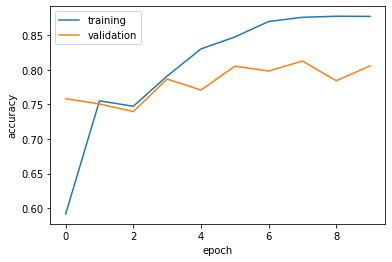

In [34]:
import matplotlib.pyplot as plt
 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','validation'], loc = 'upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()